# 0. Preparation


In [34]:
import joblib
import cv2
import numpy as np
import re
from matplotlib import pyplot as plt
from typing import Tuple, List, Dict, Optional, Any


# 1. Model Loading (OCR)


In [35]:
knn_model = joblib.load("../output/models/knn_model.pkl")
logistic_model = joblib.load("../output/models/logistic_regression_model.pkl")

# 2. Data Preprocessing


In [36]:
def preprocess_char(roi: np.ndarray) -> Optional[np.ndarray]:
    """
    Preprocess cropped ROI for model inference using
    EXACT SAME STEPS as training preprocess_digit().
    """

    # 1. ROI is already grayscale, no need for BGR2GRAY
    gray = roi.copy()

    # 2. threshold (binary inverse + Otsu)
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 3. find bounding box (same as training)
    ys, xs = np.where(bw == 255)
    if len(xs) == 0 or len(ys) == 0:
        return None

    x1, x2 = xs.min(), xs.max()
    y1, y2 = ys.min(), ys.max()
    digit = bw[y1 : y2 + 1, x1 : x2 + 1]

    # 4. resize longest side to 22 px
    h, w = digit.shape
    if h > w:
        new_h, new_w = 22, int(w * (22 / h))
    else:
        new_w, new_h = 22, int(h * (22 / w))

    digit_resized = cv2.resize(digit, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # 5. pad to 28x28
    top = (28 - new_h) // 2
    bottom = 28 - new_h - top
    left = (28 - new_w) // 2
    right = 28 - new_w - left

    digit_padded = cv2.copyMakeBorder(
        digit_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0
    )

    # 6. normalize + flatten
    digit_norm = digit_padded.astype("float32") / 255.0
    flat = digit_norm.flatten()

    return flat.reshape(1, -1)

# 3. Text Segmentation


In [37]:
def process_text_detection(
    image: np.ndarray,
) -> Tuple[
    np.ndarray, List[Tuple[int, int, int, int]], np.ndarray, np.ndarray, np.ndarray
]:
    """Your existing function - this works well"""
    original = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated = cv2.dilate(edges, kernel, iterations=2)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        if w < 20 or h < 10:
            continue
        ratio = w / float(h)
        if ratio < 0.2 or ratio > 15:
            continue
        area = w * h
        if area < 50 or area > image.shape[0] * image.shape[1] * 0.5:
            continue

        boxes.append((x, y, w, h))
        cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 2)

    return original, boxes, gray, edges, dilated


def process_line_grouping(
    boxes: List[Tuple[int, int, int, int]], line_threshold: int = 15
) -> List[List[Tuple[int, int, int, int]]]:
    """Group boxes that are on the same line"""
    if not boxes:
        return []

    # Sort by Y position
    boxes_sorted = sorted(boxes, key=lambda box: box[1])

    lines = []
    current_line = []
    current_y = boxes_sorted[0][1]

    for box in boxes_sorted:
        x, y, w, h = box

        # Check if this box is on the same line (within threshold)
        if abs(y - current_y) <= line_threshold:
            current_line.append(box)
        else:
            # New line detected
            if current_line:
                # Sort boxes in the line by X coordinate (left to right)
                current_line_sorted = sorted(current_line, key=lambda b: b[0])
                lines.append(current_line_sorted)
            current_line = [box]
            current_y = y

    # Don't forget the last line
    if current_line:
        current_line_sorted = sorted(current_line, key=lambda b: b[0])
        lines.append(current_line_sorted)

    return lines


def segment_characters_grayscale(image_gray):
    _, bw = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = sorted([cv2.boundingRect(c) for c in contours], key=lambda b: b[0])
    return boxes


def segment_characters(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # find contours (characters)
    contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # bounding boxes
    boxes = [cv2.boundingRect(c) for c in contours]

    # sort left to right
    boxes = sorted(boxes, key=lambda b: b[0])

    return boxes

# 4. Text Extraction


Some text extraction helpers


In [38]:
def predict_char_models(roi: np.ndarray) -> Tuple[str, str]:
    """
    Run prediction using both models.
    Return a tuple: (knn_char, logistic_char)
    """
    processed = preprocess_char(roi)

    if processed is None:
        return "", ""

    # KNN prediction
    knn_pred = knn_model.predict(processed)[0]

    # Logistic regression prediction
    log_pred = logistic_model.predict(processed)[0]

    return knn_pred, log_pred


def extract_text_from_line(
    image: np.ndarray, line_boxes: List[Tuple[int, int, int, int]]
) -> Tuple[str, str]:
    
    # max lines for debugging
    max_lines = 2
    shown_lines = 0
    
    
    text_knn = ""
    text_logistic = ""
    

    for (x, y, w, h) in line_boxes:
        print(f"\n=== Line {shown_lines} Bounding Box: {x, y, w, h} ===")

        # crop line region
        line_roi = image[y:y+h, x:x+w]

        # convert to grayscale if needed
        if len(line_roi.shape) == 3:
            gray_line = cv2.cvtColor(line_roi, cv2.COLOR_BGR2GRAY)
        else:
            gray_line = line_roi

        # segment characters inside this line - use grayscale version
        char_boxes = segment_characters_grayscale(gray_line)

        print(f"Characters detected in line {shown_lines}: {len(char_boxes)}")

        # visualize each character
        for i, (cx, cy, cw, ch) in enumerate(char_boxes):
            char_roi = gray_line[cy:cy+ch, cx:cx+cw]

            processed = preprocess_char(char_roi)
            if processed is None:
                print(f"   Character {i}: EMPTY or INVALID")
                continue

            processed_img = (processed.reshape(28, 28) * 255).astype("uint8")

            # Predict (optional)
            pred_knn, pred_log = predict_char_models(char_roi)
            
            text_knn += pred_knn
            text_logistic += pred_log

            # visualize only first 2 lines
            if shown_lines < max_lines:
                fig, ax = plt.subplots(1, 2, figsize=(5, 3))

                ax[0].imshow(char_roi, cmap="gray")
                ax[0].set_title(f"Raw ROI\nBox={cx,cy,cw,ch}")
                ax[0].axis("off")

                ax[1].imshow(processed_img, cmap="gray")
                ax[1].set_title(f"Preprocessed 28×28\nKNN={pred_knn}, LR={pred_log}")
                ax[1].axis("off")

                plt.suptitle(f"Line {shown_lines+1} - Character {i}")
                plt.show()

        shown_lines += 1

    return text_knn, text_logistic


# def extract_text_from_line(image: np.ndarray) -> Tuple[str, str]:
#     """
#     Make segmentation identical to your simple test script.
#     No multi-line logic, pure contour-based character detection.
#     """

#     gray = image if len(image.shape) == 2 else cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#     # SAME SEGMENTATION AS TEST SCRIPT
#     _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
#     contours, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     boxes = sorted([cv2.boundingRect(c) for c in contours], key=lambda b: b[0])

#     text_knn = ""
#     text_logistic = ""

#     for x, y, w, h in boxes:
#         char_roi = gray[y : y + h, x : x + w]

#         if char_roi.size == 0:
#             continue

#         pred_knn, pred_log = predict_char_models(char_roi)
#         text_knn += pred_knn
#         text_logistic += pred_log

#     return text_knn, text_logistic


def parse_line_by_position(line_text: str, line_number: int) -> Tuple[str, str]:
    t = line_text.lower()

    # Strong keyword-based classification
    if any(k in t for k in ["transfer berhasil", "berhasil"]):
        return "transaction_status", line_text

    if re.search(r"rp\s*\d", t):
        return "total_amount", line_text

    if any(
        m in t
        for m in [
            "wib",
            "jan",
            "feb",
            "mar",
            "apr",
            "mei",
            "jun",
            "jul",
            "agu",
            "sep",
            "okt",
            "nov",
            "des",
        ]
    ):
        return "datetime", line_text

    if "ref" in t and "id" in t:
        return "transaction_id", line_text

    if "penerima" in t:
        return "receiver_title", line_text

    # Name heuristics
    if any(prefix in t for prefix in ["sdri", "sdr", "bpk", "ibu"]):
        return "receiver_name", line_text

    if any(b in t for b in ["bni", "bca", "mandiri", "bri", "btn"]):
        return "receiver_bank", line_text

    if "sumber dana" in t:
        return "sender_title", line_text

    # Masked account
    if "***" in line_text or re.search(r"[xX]{4,}", t):
        return "sender_account", line_text

    # Detail transfer
    if "detail transfer" in t:
        return "detail_title", line_text

    # Nominal, Fee, Total lines
    if "nominal" in t:
        return "nominal_line", line_text
    if "biaya" in t:
        return "fee_line", line_text
    if t.startswith("total") or (" total " in t):
        return "total_line", line_text

    return "unknown", line_text


def extract_amount_from_text(text: str) -> Optional[int]:
    """Extract amount value from text"""
    amount_match = re.search(r"Rp\s*([\d.,]+)", text.replace(".", ""))
    if amount_match:
        amount_str = amount_match.group(1).replace(",", "")
        return int(amount_str) if amount_str.isdigit() else None
    return None


def parse_detail_line(text: str) -> Tuple[str, Optional[int]]:
    """Parse detail lines that have labels and amounts separated"""
    if "nominal" in text.lower():
        return "nominal", extract_amount_from_text(text)
    elif "biaya transaksi" in text.lower():
        return "fee", extract_amount_from_text(text)
    elif "total" in text.lower():
        return "total", extract_amount_from_text(text)
    return "unknown", None

In [39]:
def process_text_extraction(
    gray: np.ndarray, lines: List[List[Tuple[int, int, int, int]]]
) -> List[Dict[str, Any]]:
    """Step 3: Extract text from each line using both models"""
    print("\n3. Extracting text from lines...")
    lines_data = []

    for i, line_boxes in enumerate(lines):
        print(f"{i} -- Line boxes content: {type(line_boxes)} {line_boxes}")
        text_knn, text_logistic = extract_text_from_line(gray, line_boxes)

        print(f"Text KNN: {text_knn}")
        print(f"Text logistic: {text_logistic}")

        # Skip empty lines
        if (not text_knn.strip()) and (not text_logistic.strip()):
            continue

        # Parse using BOTH outputs
        field_knn, parsed_knn = parse_line_by_position(text_knn, i)
        field_log, parsed_log = parse_line_by_position(text_logistic, i)

        lines_data.append(
            {
                "line_number": i,
                "text_knn": text_knn,
                "text_logistic": text_logistic,
                "field_knn": field_knn,
                "field_logistic": field_log,
                "boxes": line_boxes,
            }
        )

    return lines_data

# 5. Verify Authenticity


In [40]:
def process_verification(
    line_items: List[Dict[str, Any]], expected_fields: Dict[str, Any]
) -> Dict[str, Any]:
    """
    Verifies extracted receipt fields using both OCR classifiers:
    - KNN
    - Logistic Regression

    Parameters:
        line_items: list of dicts (each contains OCR results)
        expected_fields: dict defining expected values or formats

    Returns:
        dict summary of:
        - knn_verification
        - logistic_verification
        - combined_verdict
    """

    results_knn = {}
    results_logistic = {}

    # --------------------------
    # PROCESS EACH EXTRACTED FIELD
    # --------------------------
    for item in line_items:
        # Each item contains OCR outputs for both models
        field_k = item.get("field_knn")
        text_k = item.get("text_knn")

        field_l = item.get("field_logistic")
        text_l = item.get("text_logistic")

        # --------------------------
        # Store KNN result
        # --------------------------
        if field_k:
            if field_k not in results_knn:
                results_knn[field_k] = text_k

        # --------------------------
        # Store Logistic result
        # --------------------------
        if field_l:
            if field_l not in results_logistic:
                results_logistic[field_l] = text_l

    # ---------------------------------
    # VERIFICATION LOGIC
    # ---------------------------------
    knn_check = {}
    logistic_check = {}

    def check_value(expected, actual):
        """Simple comparison helper."""
        if expected is None:
            return True
        return str(expected).strip() == str(actual).strip()

    # --------------------------
    # Check KNN
    # --------------------------
    for field, expected_value in expected_fields.items():
        actual = results_knn.get(field)
        knn_check[field] = {
            "expected": expected_value,
            "actual": actual,
            "match": check_value(expected_value, actual),
        }

    # --------------------------
    # Check Logistic Regression
    # --------------------------
    for field, expected_value in expected_fields.items():
        actual = results_logistic.get(field)
        logistic_check[field] = {
            "expected": expected_value,
            "actual": actual,
            "match": check_value(expected_value, actual),
        }

    # --------------------------
    # Combined final verdict
    # --------------------------
    knn_pass = all(v["match"] for v in knn_check.values())
    logistic_pass = all(v["match"] for v in logistic_check.values())

    combined = {
        "knn_pass": knn_pass,
        "logistic_pass": logistic_pass,
        "final_verdict": (
            "VALID RECEIPT" if knn_pass or logistic_pass else "POTENTIALLY FAKE"
        ),
    }

    # --------------------------
    # Return full report
    # --------------------------
    return {
        "knn_verification": knn_check,
        "logistic_verification": logistic_check,
        "combined": combined,
    }

# 6. Layout Aware Receipt Verification


Visualization function helper


In [41]:
def display_verification_results(verification: Dict[str, Any]) -> None:
    """Step 5: Display verification results in console"""
    print("\n=== VERIFICATION RESULT ===")
    print(
        f"KNN Verdict     : {'PASS' if verification['combined']['knn_pass'] else 'FAIL'}"
    )
    print(
        f"Logistic Verdict: {'PASS' if verification['combined']['logistic_pass'] else 'FAIL'}"
    )
    print(f"FINAL VERDICT   : {verification['combined']['final_verdict']}")

    # Optional reporting of matches per field
    print("\n--- KNN Field Checks ---")
    for field, info in verification["knn_verification"].items():
        print(
            f"{field}: expected={info['expected']} | actual={info['actual']} | match={info['match']}"
        )

    print("\n--- Logistic Field Checks ---")
    for field, info in verification["logistic_verification"].items():
        print(
            f"{field}: expected={info['expected']} | actual={info['actual']} | match={info['match']}"
        )


def create_legend_image(lines_data: List[Dict[str, Any]]) -> np.ndarray:
    """Create legend image showing detected field types"""
    colors = get_field_colors()
    legend_img = np.ones((400, 400, 3), dtype=np.uint8) * 255
    y_offset = 30

    for field_type, color in colors.items():
        if any(field_type == line["field_knn"] for line in lines_data):
            cv2.putText(
                legend_img,
                field_type,
                (10, y_offset),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.4,
                color,
                1,
            )
            y_offset += 20

    return legend_img


def visualize_results(
    image: np.ndarray,
    result_img: np.ndarray,
    annotated_img: np.ndarray,
    lines_data: List[Dict[str, Any]],
) -> None:
    """Step 6: Create and display visualization"""
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    plt.title("Text Detection")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.title("Layout Analysis")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    legend_img = create_legend_image(lines_data)
    plt.imshow(cv2.cvtColor(legend_img, cv2.COLOR_BGR2RGB))
    plt.title("Detected Field Types")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Anotation helper


In [42]:
def get_field_colors() -> Dict[str, Tuple[int, int, int]]:
    """Get color mapping for different field types"""
    return {
        "app_logo": (255, 0, 0),  # Red
        "bank_name": (0, 0, 255),  # Blue
        "transaction_status": (0, 255, 0),  # Green
        "total_amount": (255, 255, 0),  # Cyan
        "datetime": (255, 0, 255),  # Magenta
        "transaction_id": (0, 255, 255),  # Yellow
        "receiver_title": (128, 0, 128),  # Purple
        "receiver_name": (128, 128, 0),  # Olive
        "receiver_bank": (0, 128, 128),  # Teal
        "sender_title": (128, 128, 128),  # Gray
        "sender_name": (64, 64, 64),  # Dark Gray
        "sender_account": (192, 192, 192),  # Light Gray
        "detail_title": (255, 165, 0),  # Orange
        "nominal_line": (255, 192, 203),  # Pink
        "fee_line": (173, 216, 230),  # Light Blue
        "total_line": (144, 238, 144),  # Light Green
        "unknown": (0, 0, 0),  # Black
    }


def create_annotated_image(
    image: np.ndarray, lines_data: List[Dict[str, Any]], verification: Dict[str, Any]
) -> np.ndarray:
    """Create annotated image with bounding boxes and labels"""
    annotated_img = image.copy()
    colors = get_field_colors()

    # Draw annotated boxes
    for line_data in lines_data:
        field_type = line_data["field_knn"]
        color = colors.get(field_type, (0, 0, 0))

        for box in line_data["boxes"]:
            x, y, w, h = box
            cv2.rectangle(annotated_img, (x, y), (x + w, y + h), color, 2)

        # Add field type label using first box in line
        if line_data["boxes"]:
            x, y, w, h = line_data["boxes"][0]
            label = line_data["field_knn"]
            cv2.putText(
                annotated_img,
                label,
                (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                2,
            )

    # Add final result to image
    final_result = verification["combined"]["final_verdict"]
    knn_pass = verification["combined"]["knn_pass"]
    log_pass = verification["combined"]["logistic_pass"]

    confidence = int((knn_pass + log_pass) / 2 * 100)
    result_text = f"Result: {final_result} ({confidence}%)"

    cv2.putText(
        annotated_img, result_text, (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 3
    )

    return annotated_img

Layout aware receipt verification


In [43]:
def layout_aware_receipt_verification(
    image_path: str, expected_amount: Optional[Dict[str, Any]] = None
) -> Tuple[Dict[str, Any], List[Dict[str, Any]]]:
    """Complete pipeline with layout awareness"""
    print("=== LAYOUT-AWARE RECEIPT VERIFICATION ===")

    # Load and validate image
    image = cv2.imread(image_path)
    if image is None:
        return {}, []

    # Step 1: Detect text regions
    result_img, boxes, gray, edges, dilated = process_text_detection(image)

    # Step 2: Group boxes by lines
    lines = process_line_grouping(boxes, line_threshold=15)

    # Step 3: Extract text from each line
    lines_data = process_text_extraction(gray, lines)

    # Step 4: Verify authenticity
    verification = process_verification(lines_data, expected_amount)

    # Step 5: Display results
    display_verification_results(verification)

    # Step 6: Create visualization
    annotated_img = create_annotated_image(image, lines_data, verification)
    visualize_results(image, result_img, annotated_img, lines_data)

    return verification, lines_data

# 7. Testing


=== LAYOUT-AWARE RECEIPT VERIFICATION ===

3. Extracting text from lines...
0 -- Line boxes content: <class 'list'> [(330, 83, 420, 142)]

=== Line 0 Bounding Box: (330, 83, 420, 142) ===
Characters detected in line 0: 11


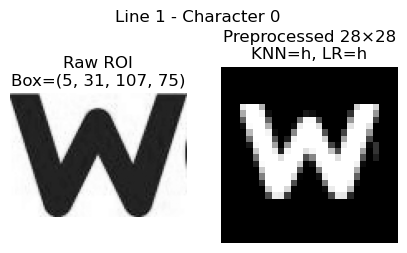

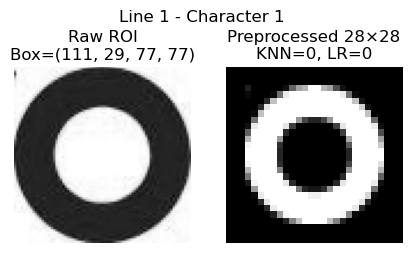

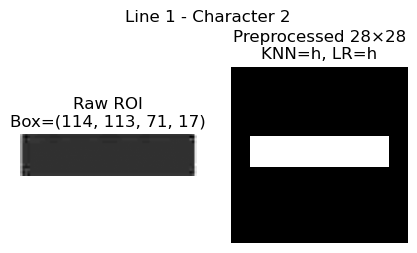

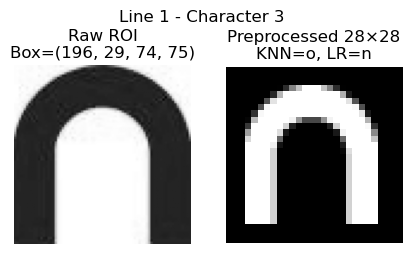

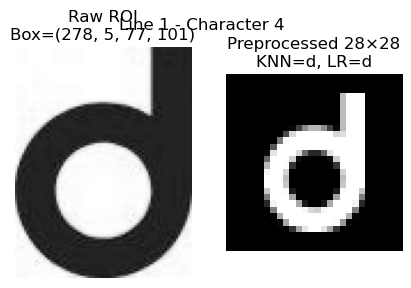

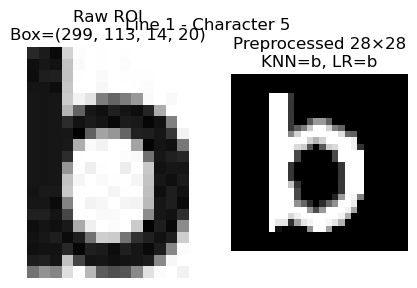

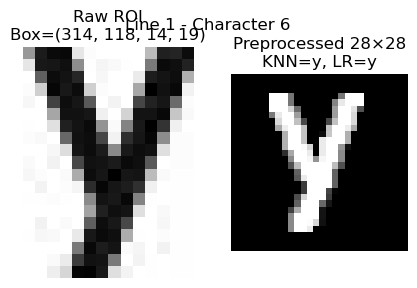

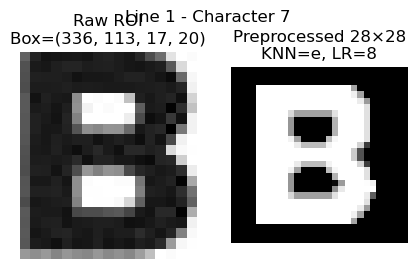

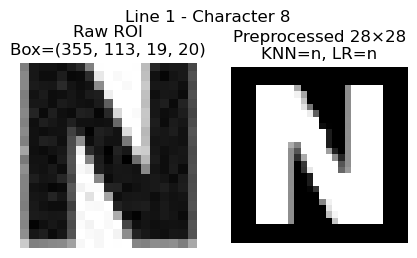

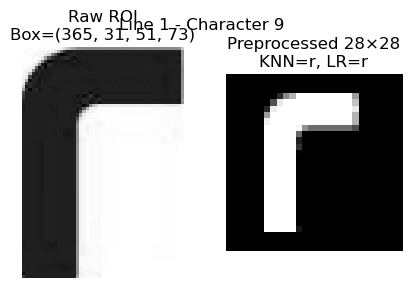

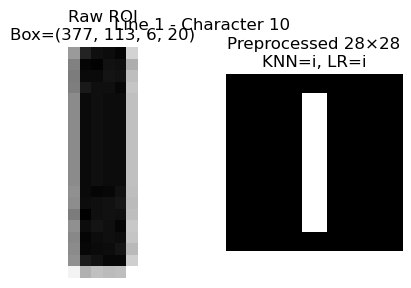

Text KNN: h0hodbyenri
Text logistic: h0hndby8nri
1 -- Line boxes content: <class 'list'> [(341, 295, 201, 45), (548, 293, 189, 47)]

=== Line 0 Bounding Box: (341, 295, 201, 45) ===
Characters detected in line 0: 8


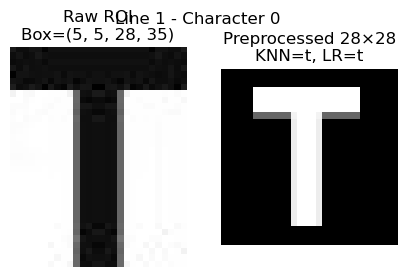

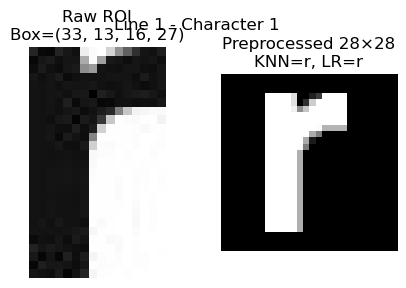

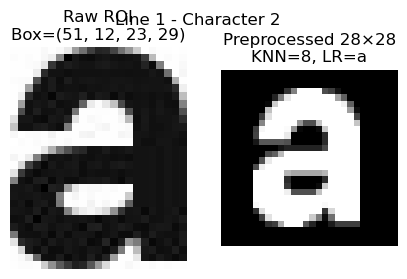

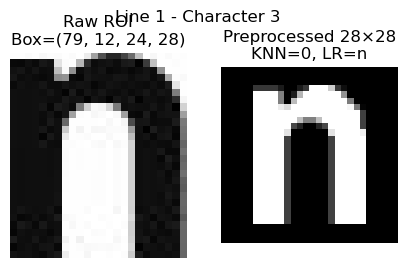

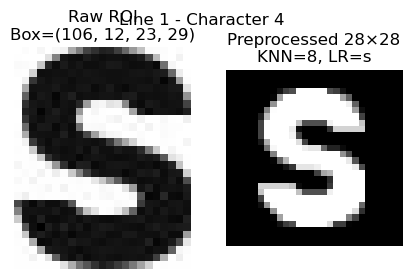

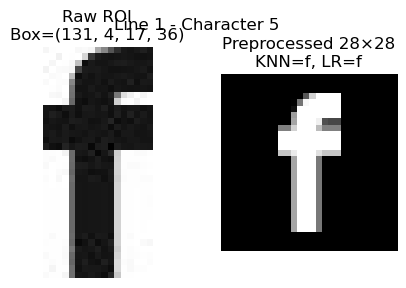

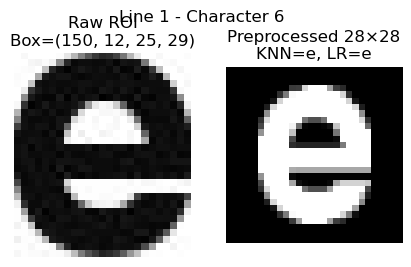

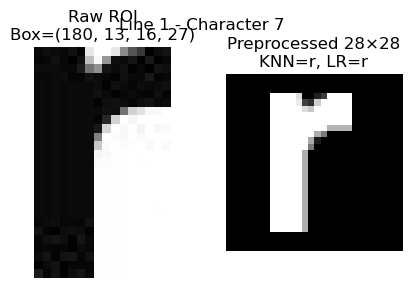


=== Line 1 Bounding Box: (548, 293, 189, 47) ===
Characters detected in line 1: 9


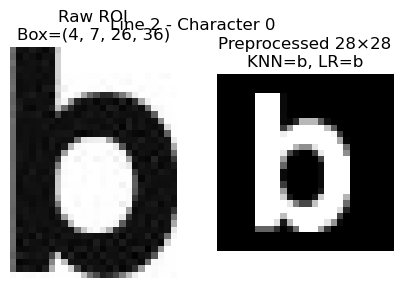

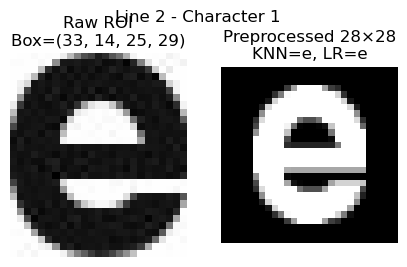

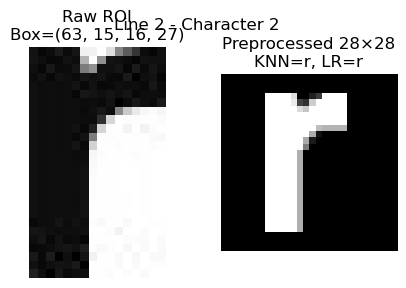

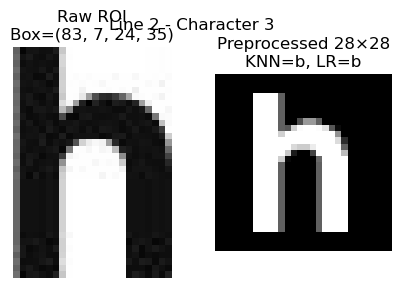

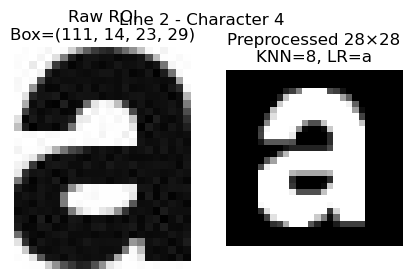

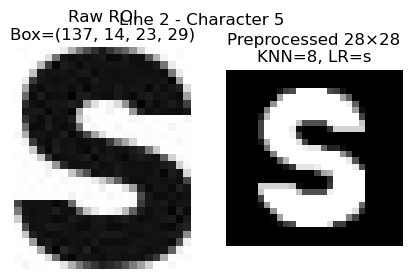

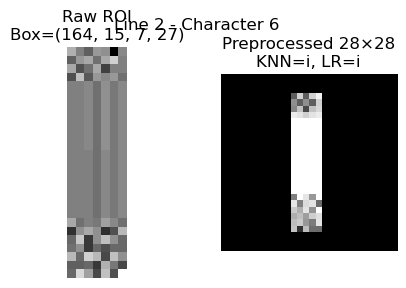

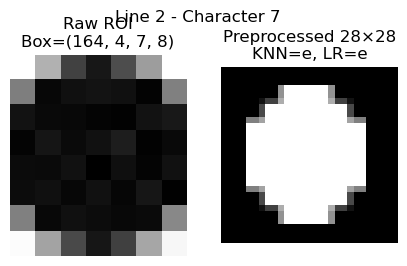

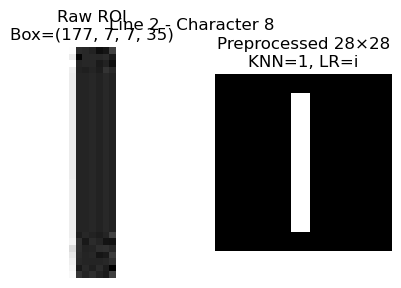

Text KNN: tr808ferberb88ie1
Text logistic: transferberbasiei
2 -- Line boxes content: <class 'list'> [(383, 406, 316, 68)]

=== Line 0 Bounding Box: (383, 406, 316, 68) ===
Characters detected in line 0: 8


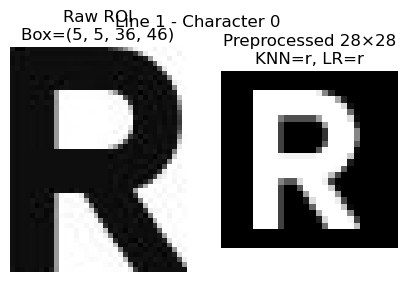

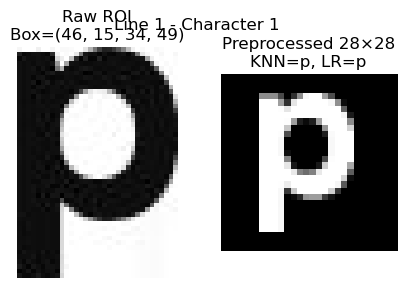

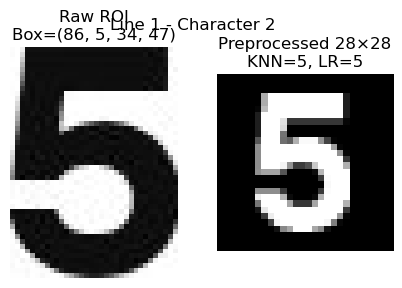

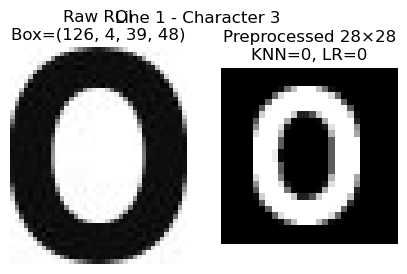

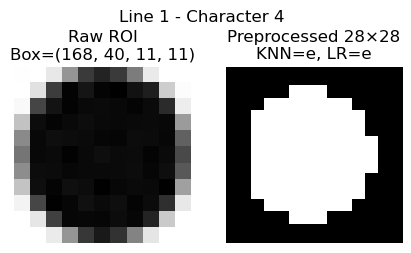

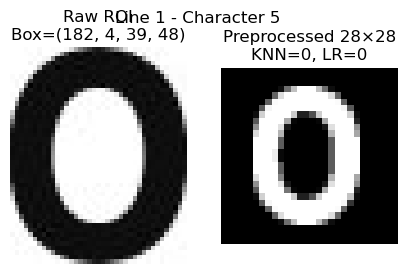

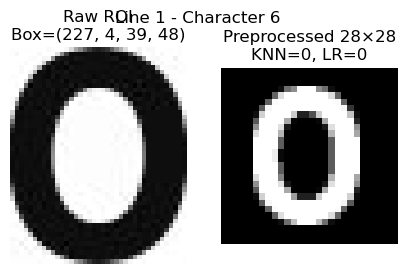

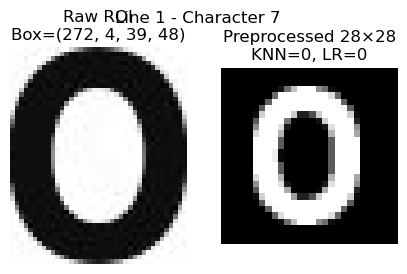

Text KNN: rp50e000
Text logistic: rp50e000
3 -- Line boxes content: <class 'list'> [(289, 528, 53, 37), (345, 528, 73, 37), (419, 528, 93, 37), (539, 528, 142, 37), (683, 528, 76, 37)]

=== Line 0 Bounding Box: (289, 528, 53, 37) ===
Characters detected in line 0: 2


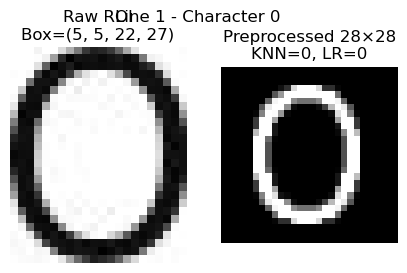

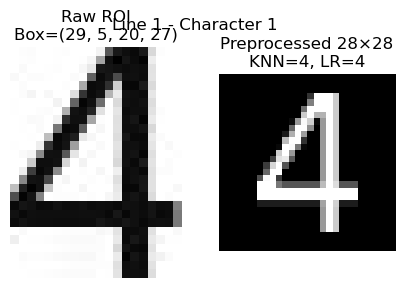


=== Line 1 Bounding Box: (345, 528, 73, 37) ===
Characters detected in line 1: 3


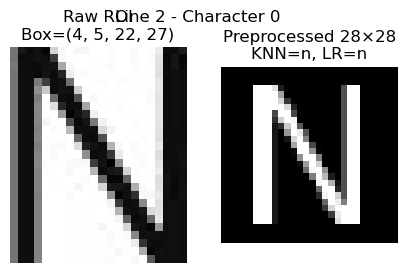

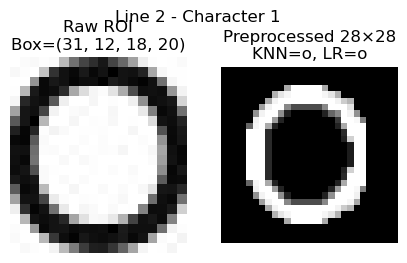

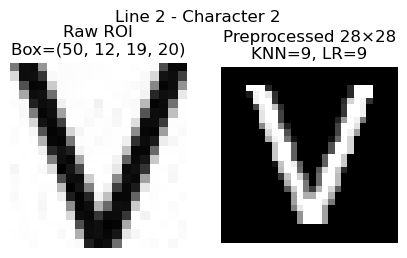


=== Line 2 Bounding Box: (419, 528, 93, 37) ===
Characters detected in line 2: 4

=== Line 3 Bounding Box: (539, 528, 142, 37) ===
Characters detected in line 3: 10

=== Line 4 Bounding Box: (683, 528, 76, 37) ===
Characters detected in line 4: 3
Text KNN: 04no9202522bb416606618
Text logistic: 04no9202522bb41440661b
4 -- Line boxes content: <class 'list'> [(270, 582, 62, 37), (335, 582, 47, 37), (386, 582, 426, 37)]

=== Line 0 Bounding Box: (270, 582, 62, 37) ===
Characters detected in line 0: 3

=== Line 4 Bounding Box: (683, 528, 76, 37) ===
Characters detected in line 4: 3
Text KNN: 04no9202522bb416606618
Text logistic: 04no9202522bb41440661b
4 -- Line boxes content: <class 'list'> [(270, 582, 62, 37), (335, 582, 47, 37), (386, 582, 426, 37)]

=== Line 0 Bounding Box: (270, 582, 62, 37) ===
Characters detected in line 0: 3


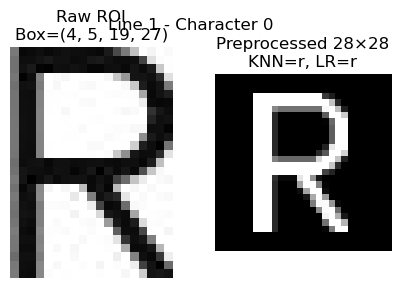

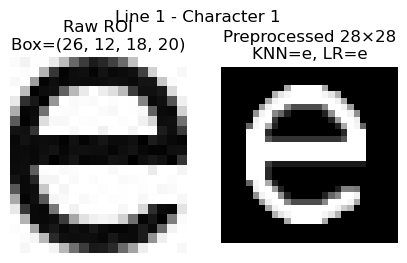

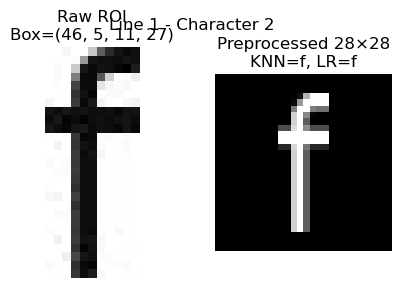


=== Line 1 Bounding Box: (335, 582, 47, 37) ===
Characters detected in line 1: 4


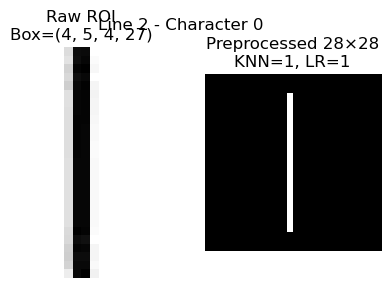

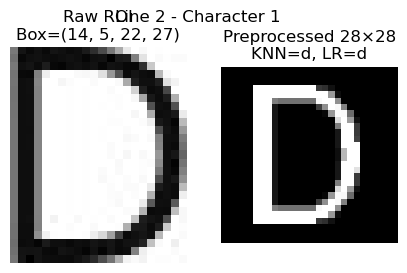

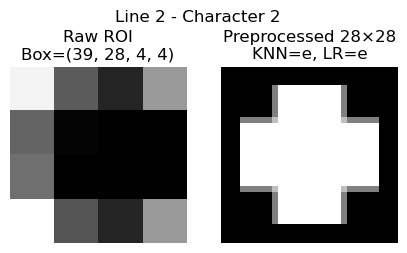

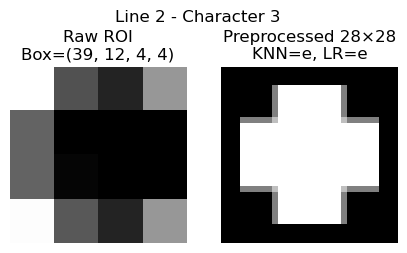


=== Line 2 Bounding Box: (386, 582, 426, 37) ===
Characters detected in line 2: 20
Text KNN: ref1dee20251104104059000887
Text logistic: ref1dee20251104104059000887
5 -- Line boxes content: <class 'list'> [(64, 675, 174, 39)]

=== Line 0 Bounding Box: (64, 675, 174, 39) ===
Characters detected in line 0: 9
Text KNN: ref1dee20251104104059000887
Text logistic: ref1dee20251104104059000887
5 -- Line boxes content: <class 'list'> [(64, 675, 174, 39)]

=== Line 0 Bounding Box: (64, 675, 174, 39) ===
Characters detected in line 0: 9


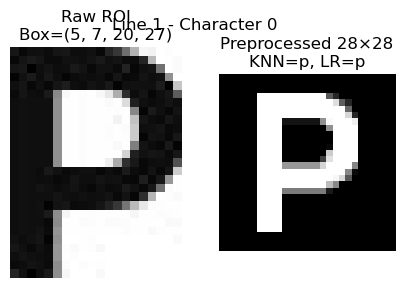

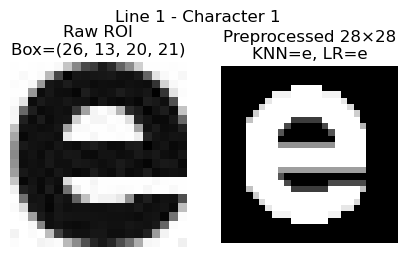

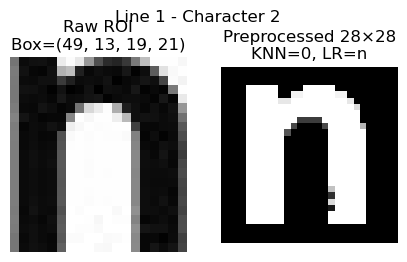

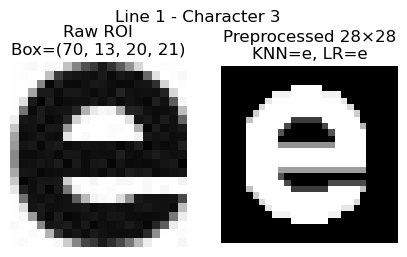

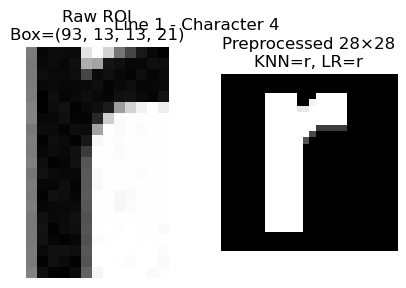

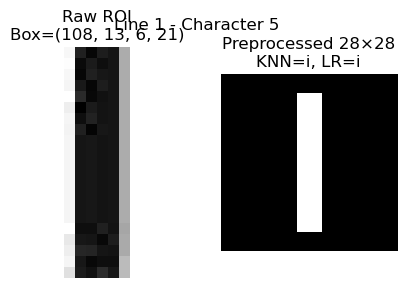

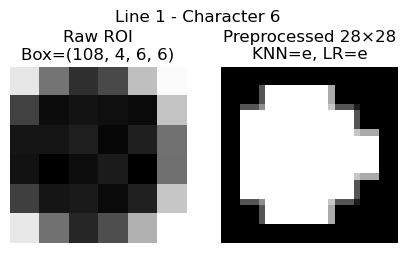

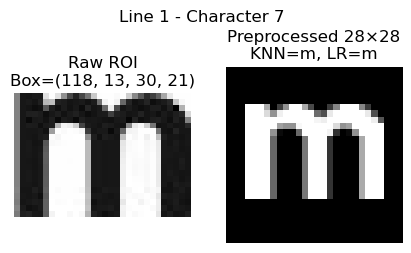

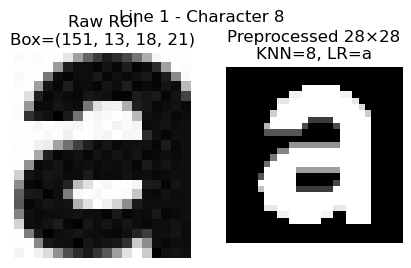

Text KNN: pe0eriem8
Text logistic: peneriema
6 -- Line boxes content: <class 'list'> [(63, 764, 70, 37), (138, 764, 62, 37), (203, 764, 177, 37)]

=== Line 0 Bounding Box: (63, 764, 70, 37) ===
Characters detected in line 0: 5


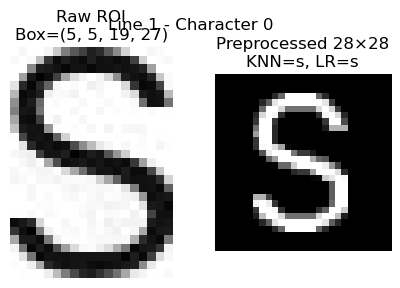

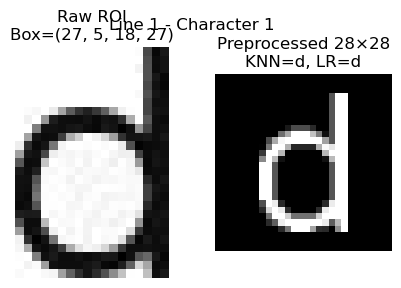

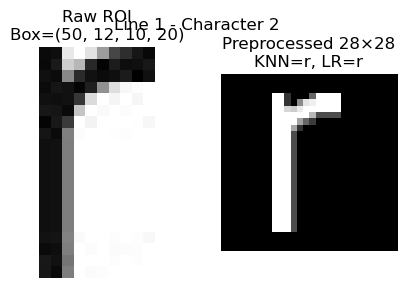

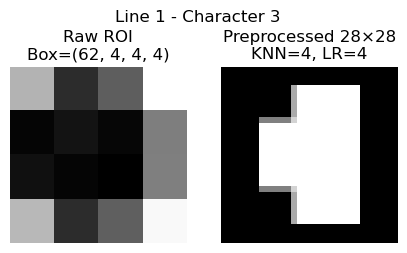

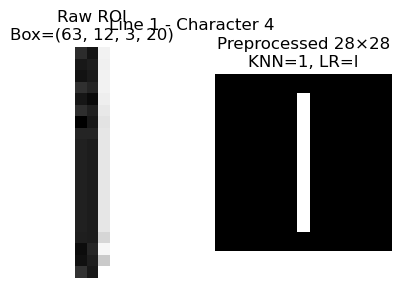


=== Line 1 Bounding Box: (138, 764, 62, 37) ===
Characters detected in line 1: 3


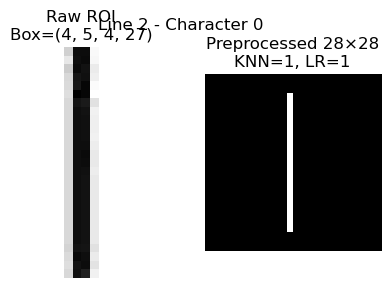

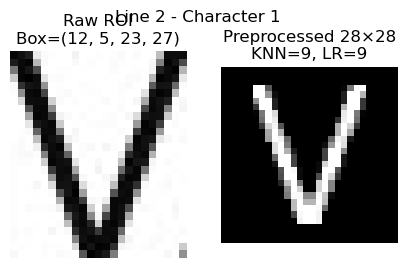

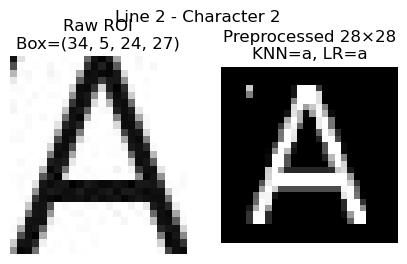


=== Line 2 Bounding Box: (203, 764, 177, 37) ===
Characters detected in line 2: 8
Text KNN: sdr4119akr1st09a
Text logistic: sdr4l19akr1sto9a
7 -- Line boxes content: <class 'list'> [(65, 829, 65, 37), (158, 829, 212, 37)]

=== Line 0 Bounding Box: (65, 829, 65, 37) ===
Characters detected in line 0: 3
Text KNN: sdr4119akr1st09a
Text logistic: sdr4l19akr1sto9a
7 -- Line boxes content: <class 'list'> [(65, 829, 65, 37), (158, 829, 212, 37)]

=== Line 0 Bounding Box: (65, 829, 65, 37) ===
Characters detected in line 0: 3


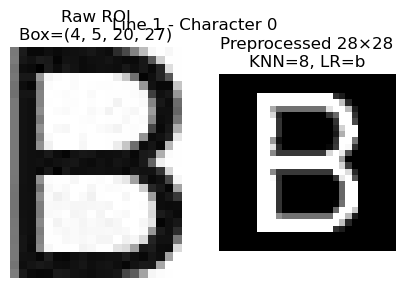

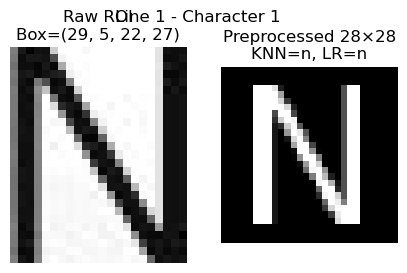

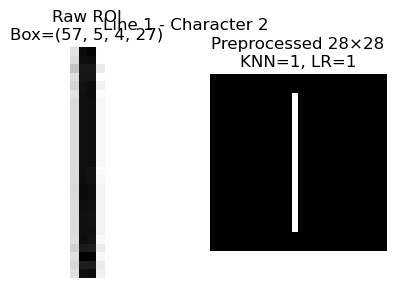


=== Line 1 Bounding Box: (158, 829, 212, 37) ===
Characters detected in line 1: 10


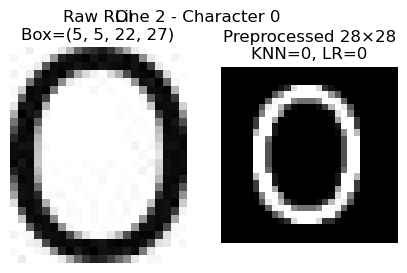

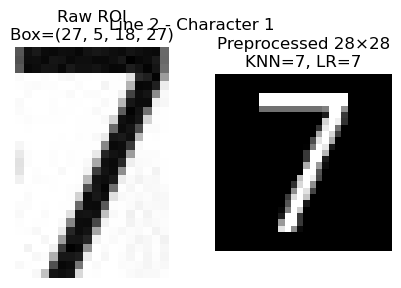

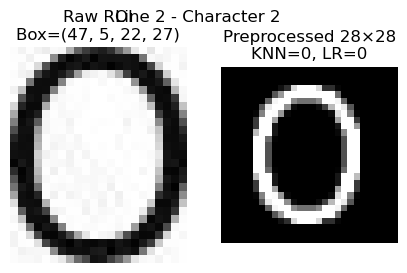

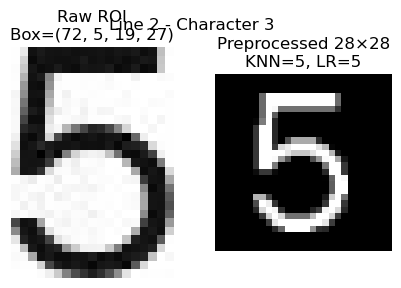

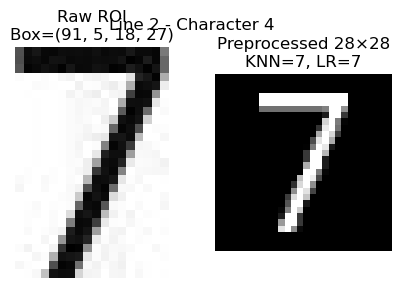

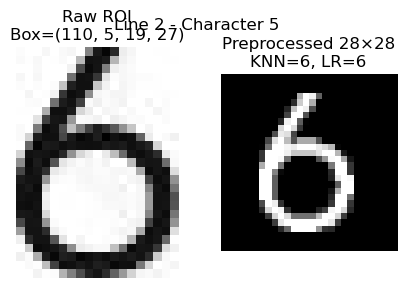

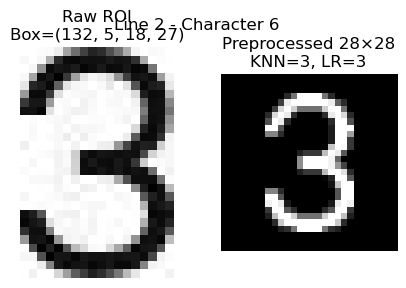

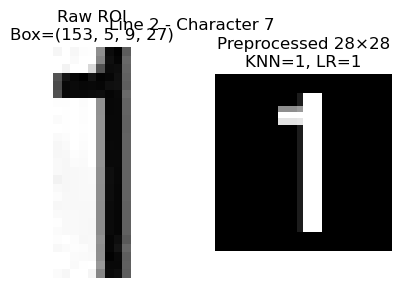

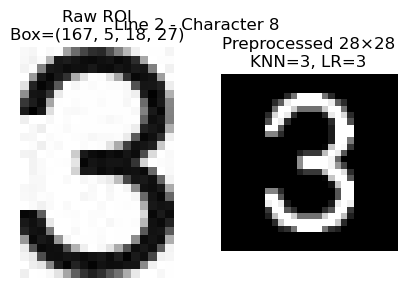

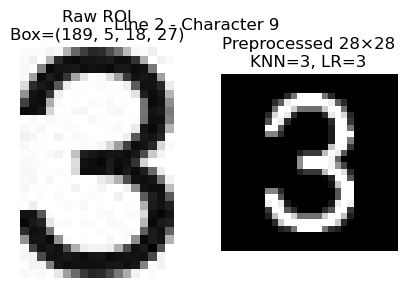

Text KNN: 8n10705763133
Text logistic: bn10705763133
8 -- Line boxes content: <class 'list'> [(63, 925, 150, 35), (214, 925, 94, 35)]

=== Line 0 Bounding Box: (63, 925, 150, 35) ===
Characters detected in line 0: 6


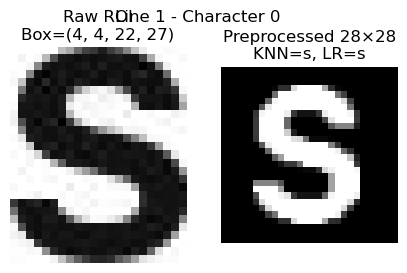

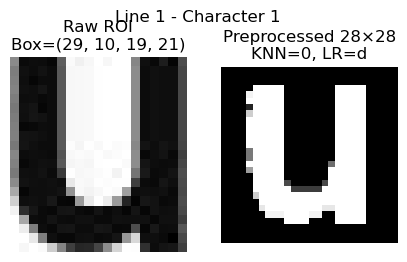

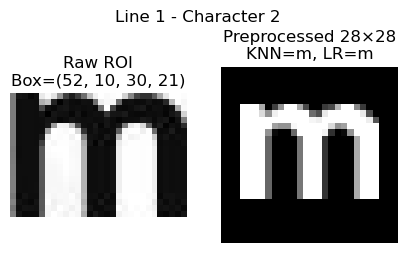

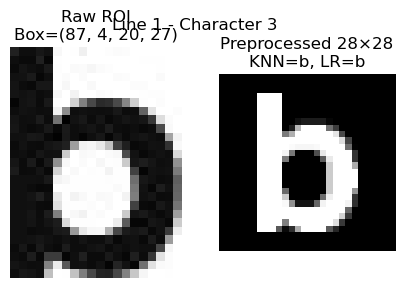

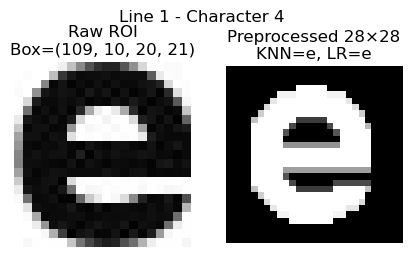

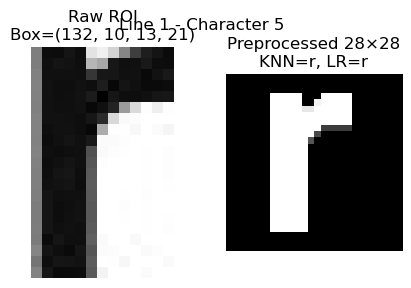


=== Line 1 Bounding Box: (214, 925, 94, 35) ===
Characters detected in line 1: 4


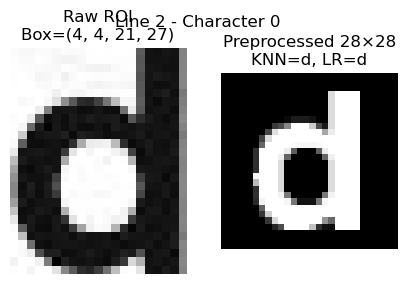

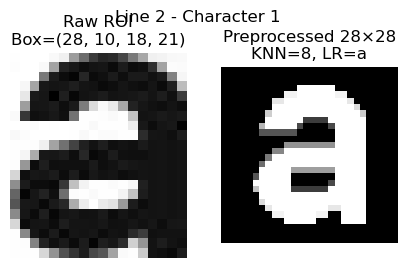

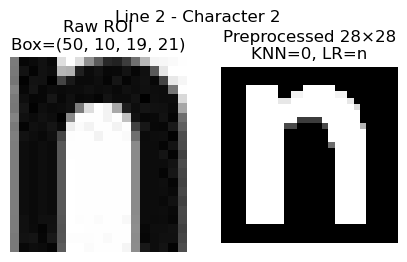

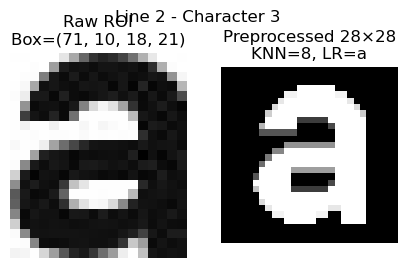

Text KNN: s0mberd808
Text logistic: sdmberdana
9 -- Line boxes content: <class 'list'> [(65, 1011, 231, 37), (300, 1011, 113, 37)]

=== Line 0 Bounding Box: (65, 1011, 231, 37) ===
Characters detected in line 0: 8


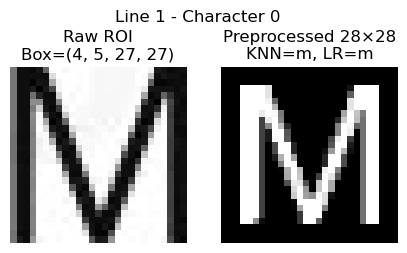

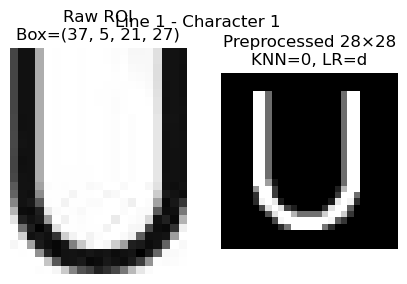

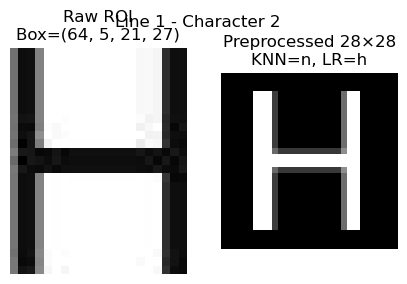

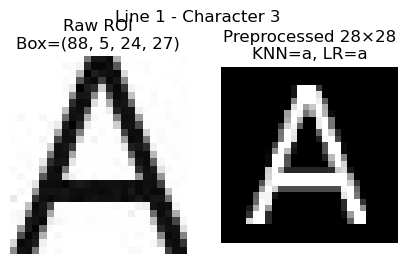

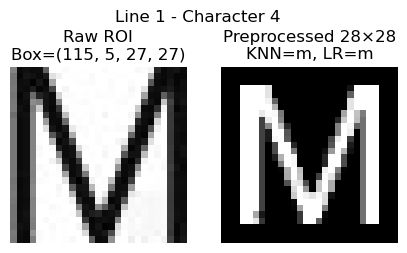

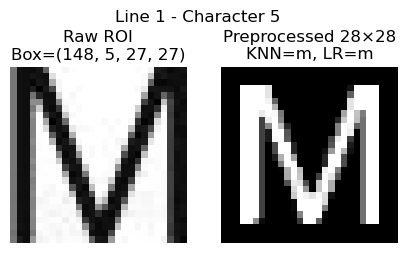

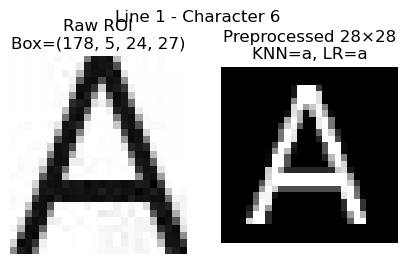

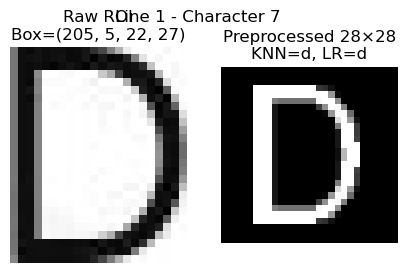


=== Line 1 Bounding Box: (300, 1011, 113, 37) ===
Characters detected in line 1: 5


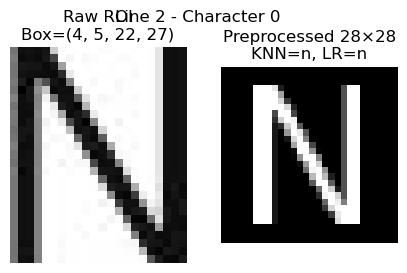

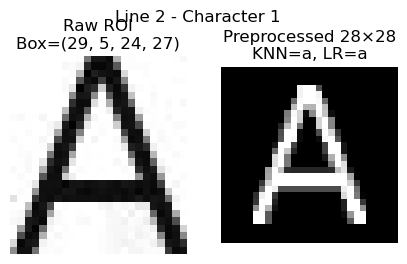

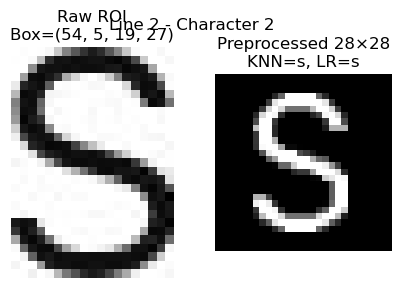

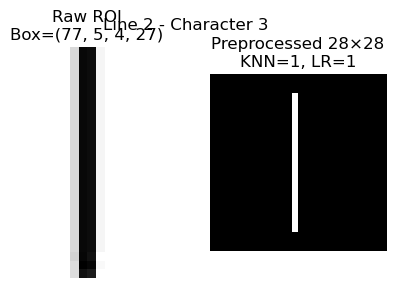

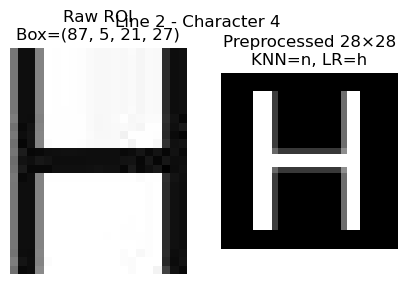

Text KNN: m0nammadnas1n
Text logistic: mdhammadnas1h
10 -- Line boxes content: <class 'list'> [(63, 1076, 195, 37)]

=== Line 0 Bounding Box: (63, 1076, 195, 37) ===
Characters detected in line 0: 10


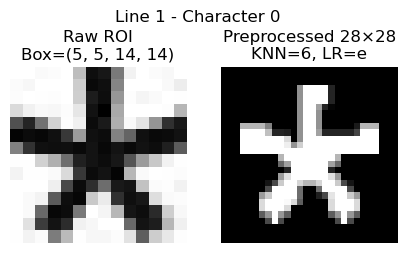

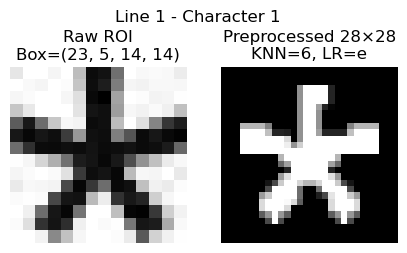

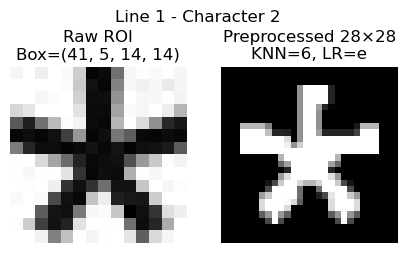

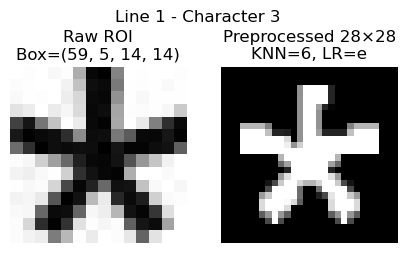

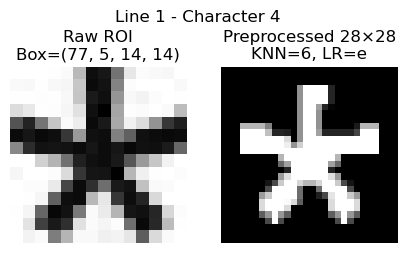

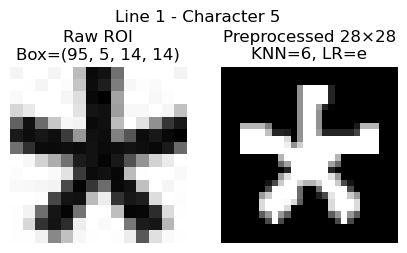

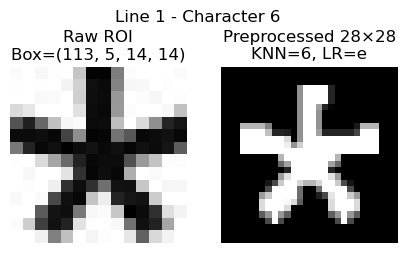

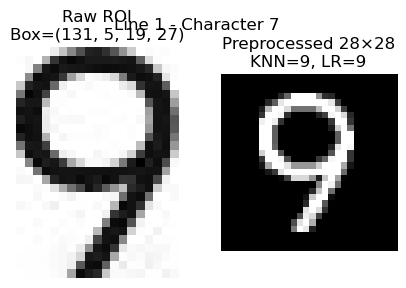

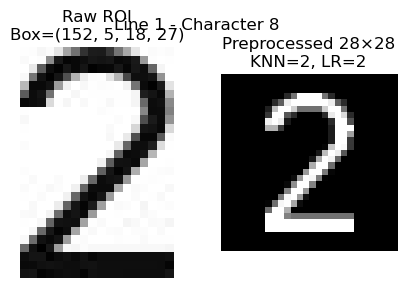

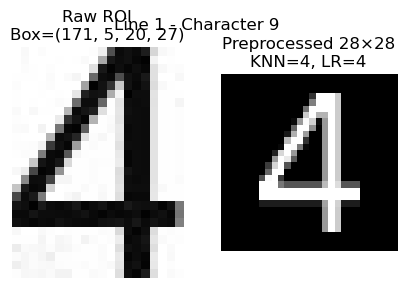

Text KNN: 6666666924
Text logistic: eeeeeee924
11 -- Line boxes content: <class 'list'> [(64, 1169, 109, 39), (176, 1171, 154, 36)]

=== Line 0 Bounding Box: (64, 1169, 109, 39) ===
Characters detected in line 0: 7


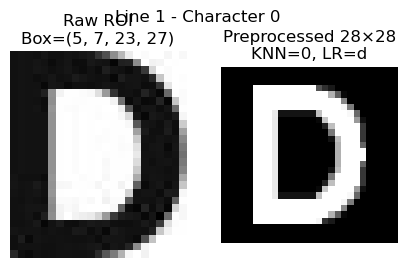

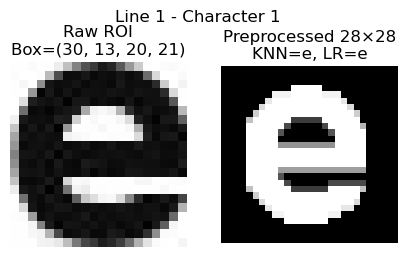

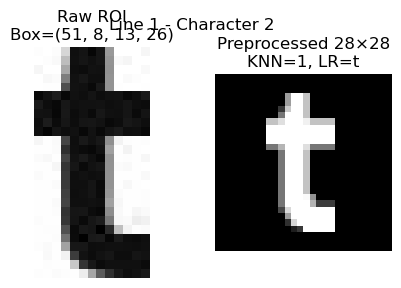

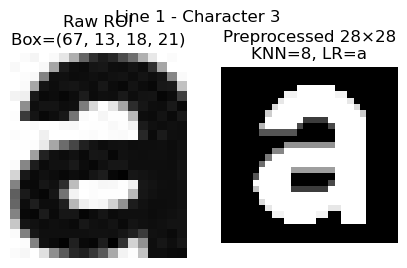

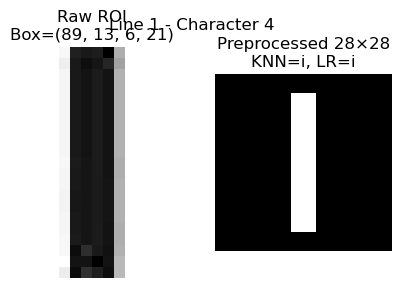

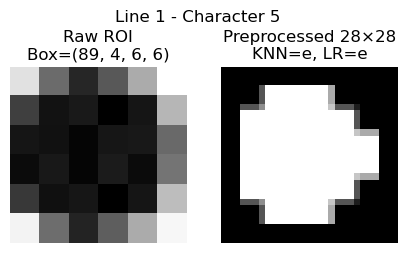

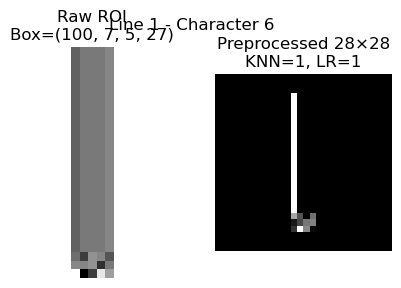


=== Line 1 Bounding Box: (176, 1171, 154, 36) ===
Characters detected in line 1: 8


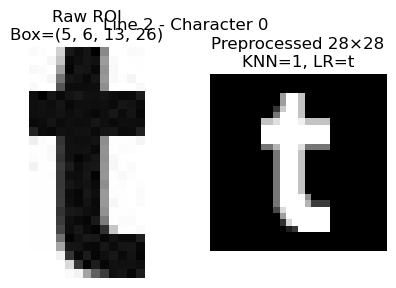

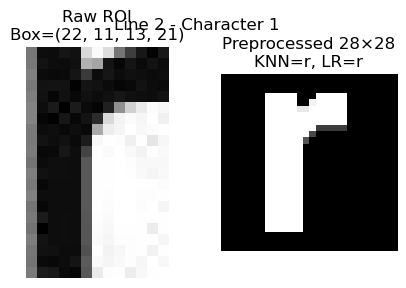

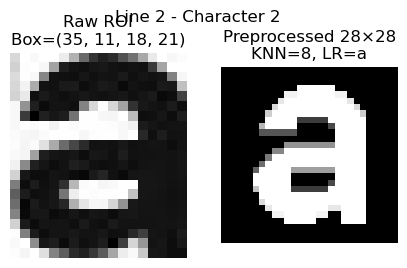

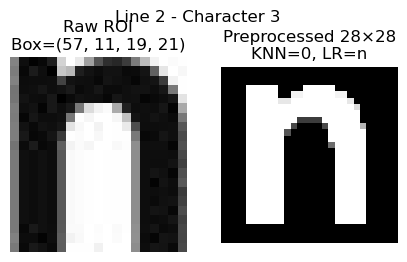

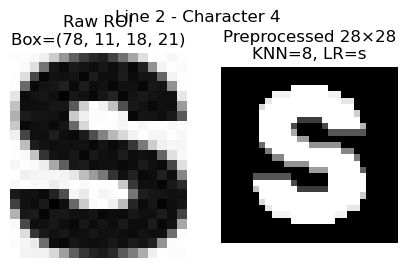

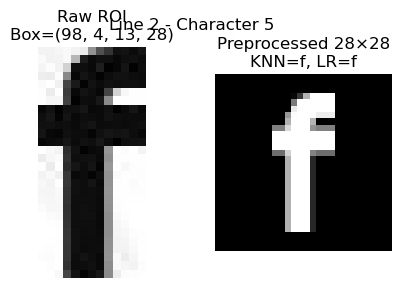

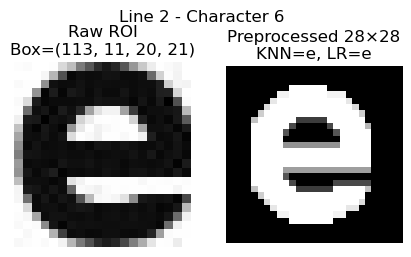

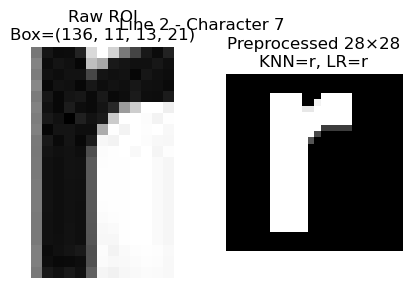

Text KNN: 0e18ie11r808fer
Text logistic: detaie1transfer
12 -- Line boxes content: <class 'list'> [(65, 1269, 142, 37), (840, 1269, 178, 44)]

=== Line 0 Bounding Box: (65, 1269, 142, 37) ===
Characters detected in line 0: 8


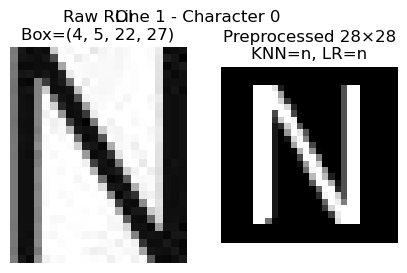

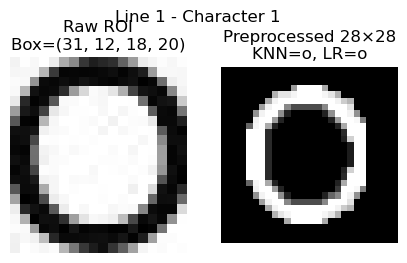

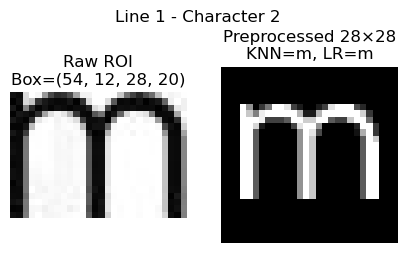

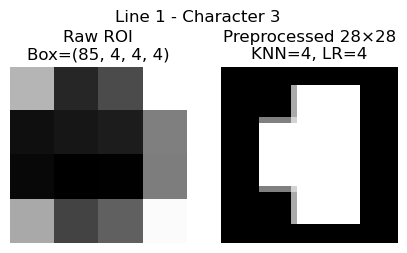

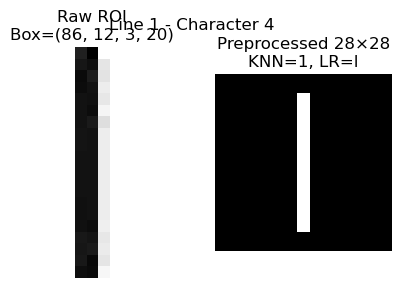

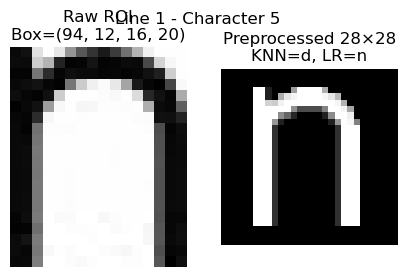

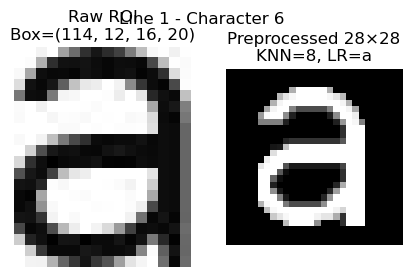

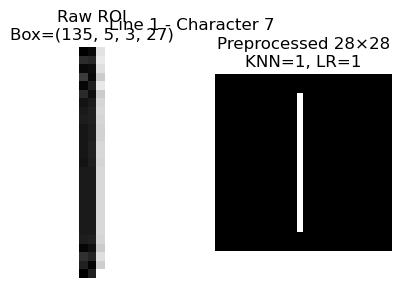


=== Line 1 Bounding Box: (840, 1269, 178, 44) ===
Characters detected in line 1: 8


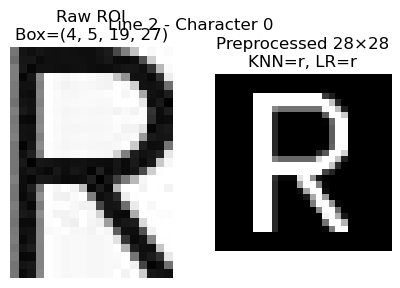

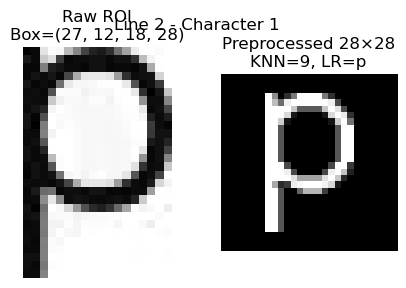

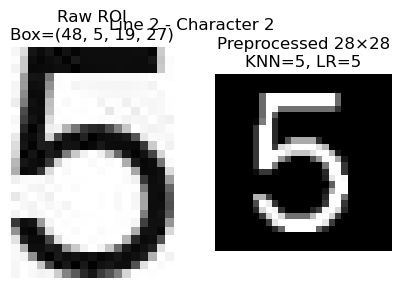

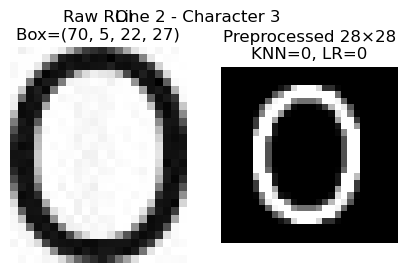

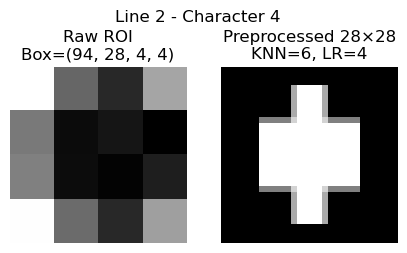

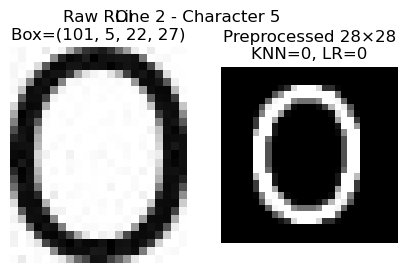

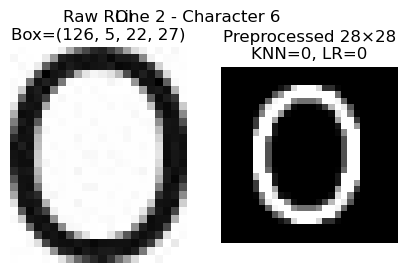

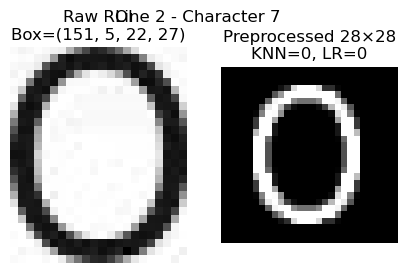

Text KNN: nom41d81r9506000
Text logistic: nom4lna1rp504000
13 -- Line boxes content: <class 'list'> [(65, 1356, 94, 45), (161, 1356, 155, 37), (943, 1356, 75, 44)]

=== Line 0 Bounding Box: (65, 1356, 94, 45) ===
Characters detected in line 0: 6


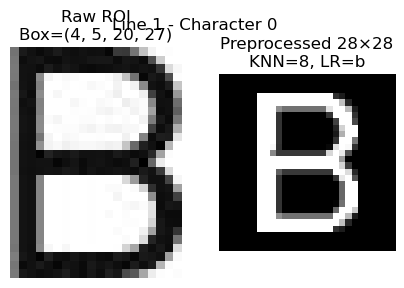

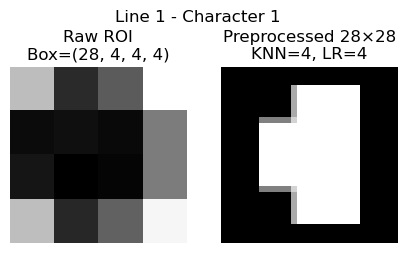

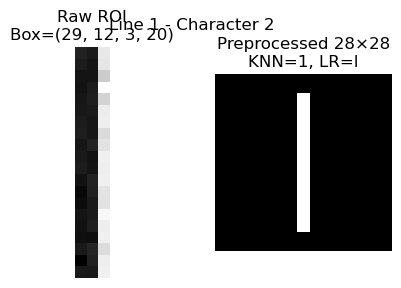

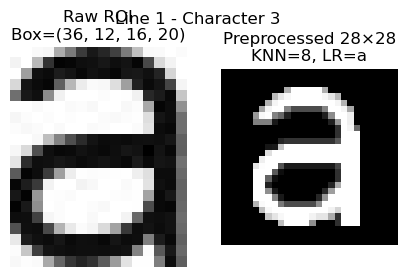

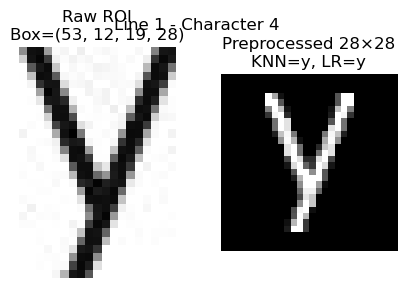

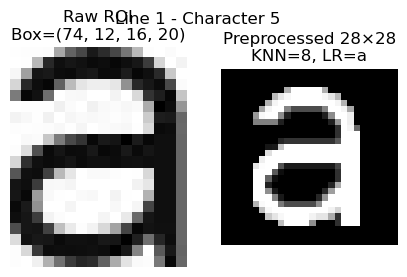


=== Line 1 Bounding Box: (161, 1356, 155, 37) ===
Characters detected in line 1: 10


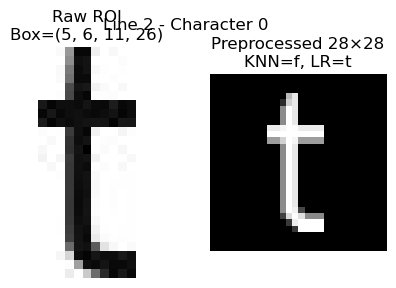

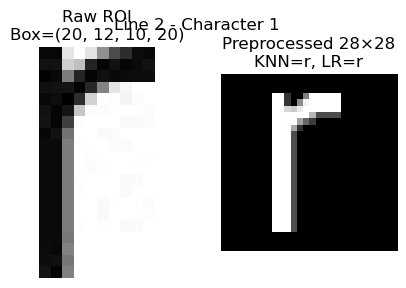

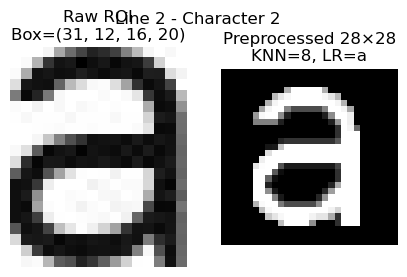

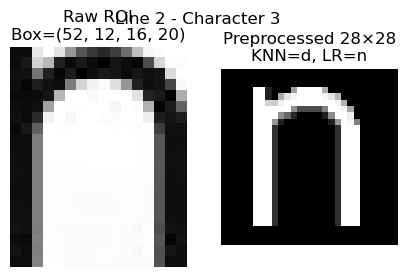

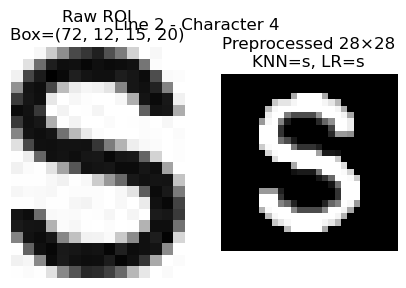

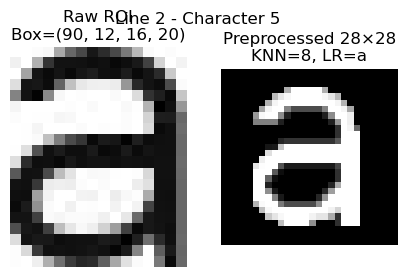

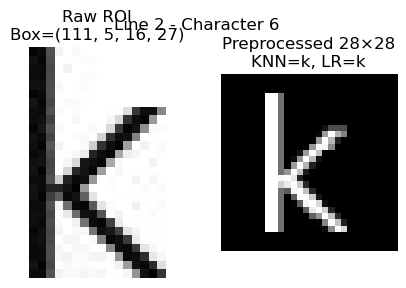

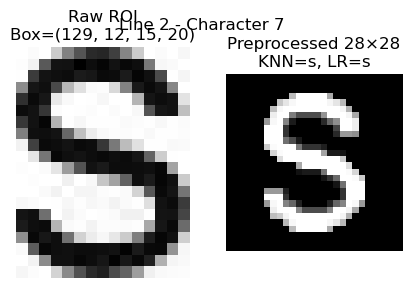

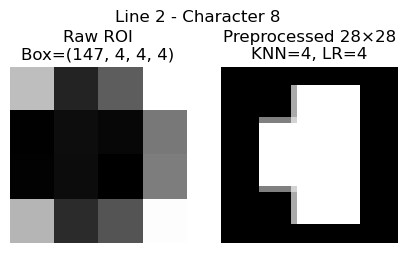

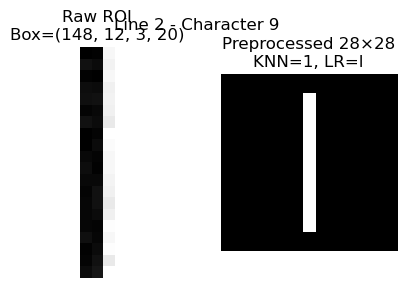


=== Line 2 Bounding Box: (943, 1356, 75, 44) ===
Characters detected in line 2: 3
Text KNN: 8418y8fr8ds8ks41r90
Text logistic: b4layatransaks4lrp0
14 -- Line boxes content: <class 'list'> [(62, 1494, 86, 37), (700, 1485, 316, 69)]

=== Line 0 Bounding Box: (62, 1494, 86, 37) ===
Characters detected in line 0: 5


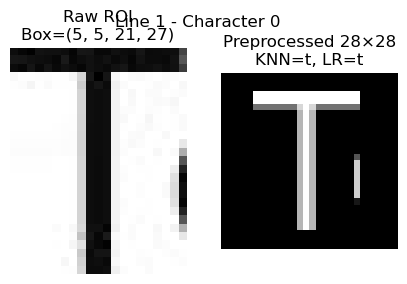

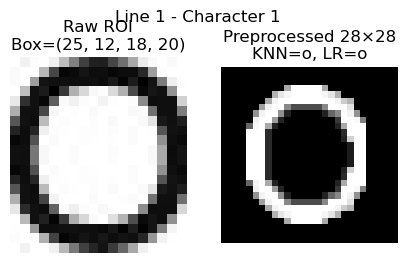

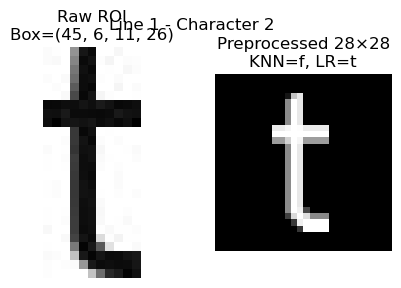

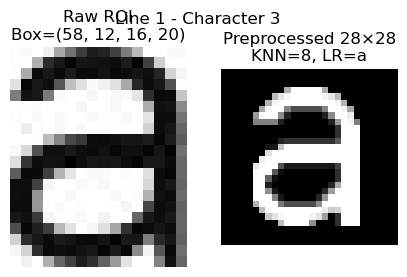

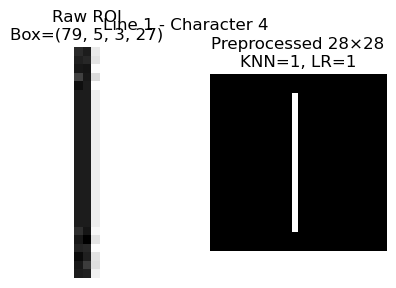


=== Line 1 Bounding Box: (700, 1485, 316, 69) ===
Characters detected in line 1: 8


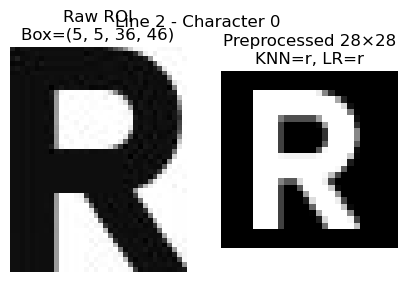

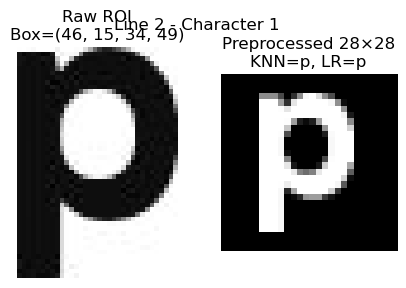

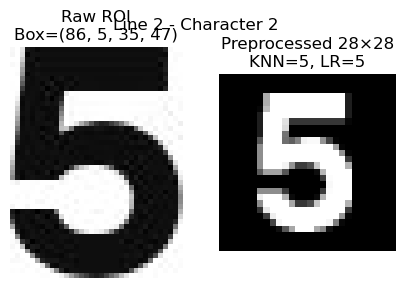

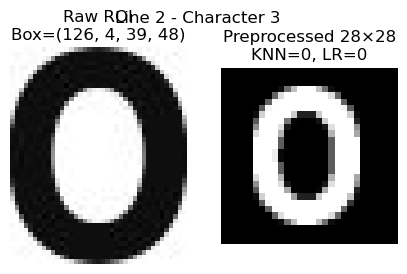

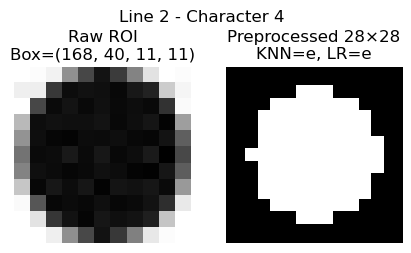

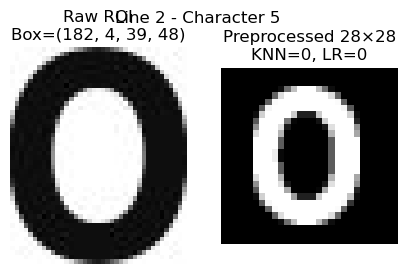

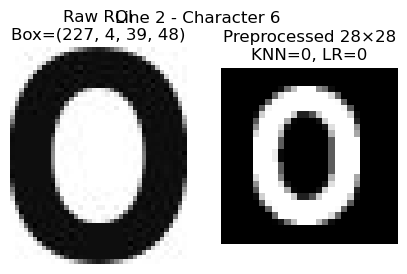

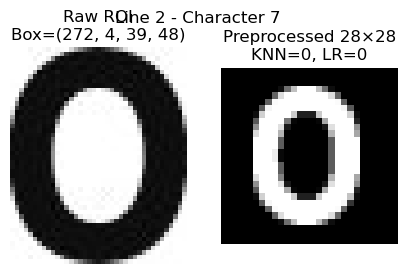

Text KNN: tof81rp50e000
Text logistic: tota1rp50e000

=== VERIFICATION RESULT ===
KNN Verdict     : FAIL
Logistic Verdict: FAIL
FINAL VERDICT   : POTENTIALLY FAKE

--- KNN Field Checks ---
total_amount: expected=50000 | actual=rp50e000 | match=False

--- Logistic Field Checks ---
total_amount: expected=50000 | actual=rp50e000 | match=False


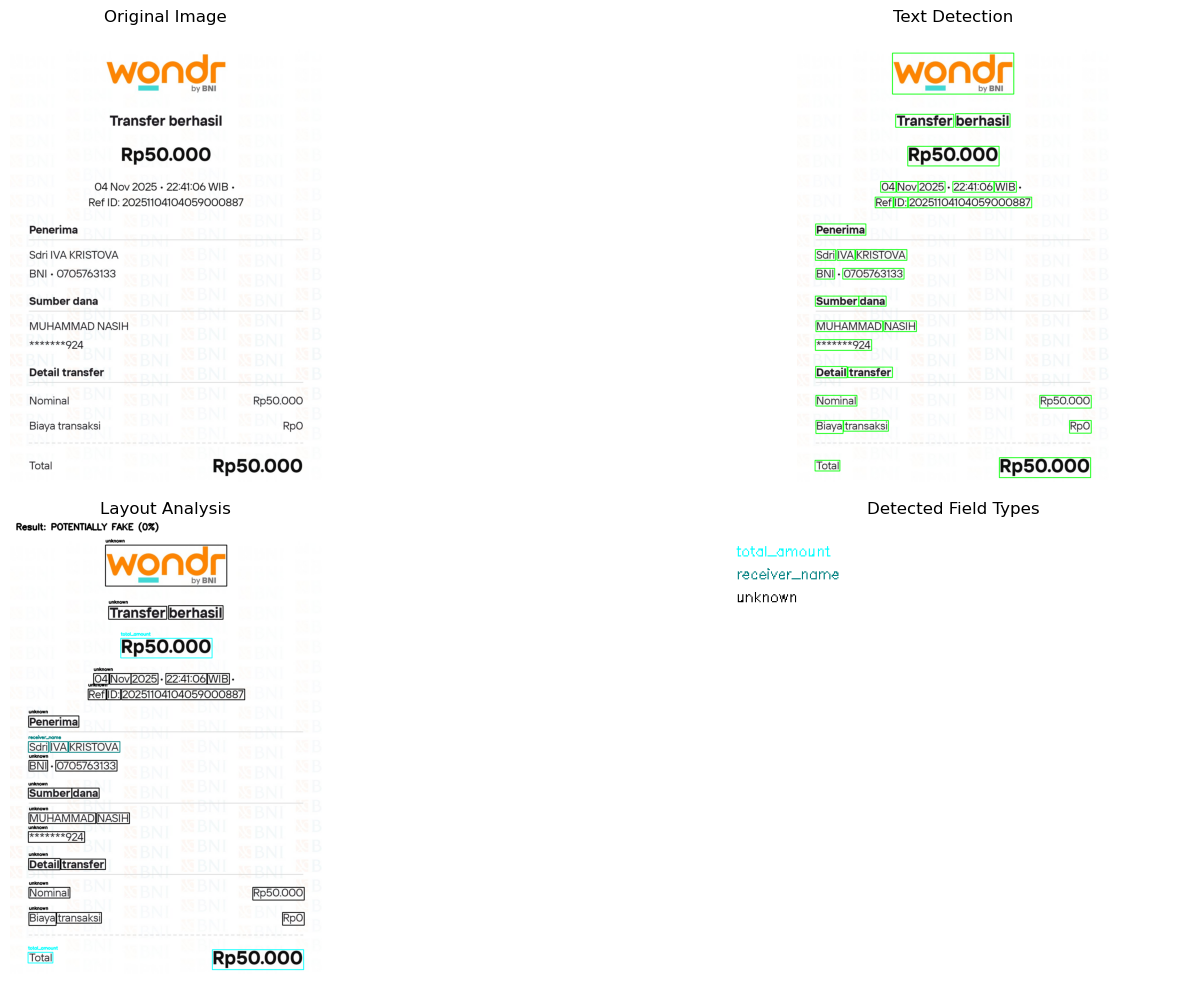


DETAILED LAYOUT ANALYSIS:
Line  0:
   KNN     -> unknown         | 'h0hodbyenri'
   Logistic-> unknown         | 'h0hndby8nri'
Line  1:
   KNN     -> unknown         | 'tr808ferberb88ie1'
   Logistic-> unknown         | 'transferberbasiei'
Line  2:
   KNN     -> total_amount    | 'rp50e000'
   Logistic-> total_amount    | 'rp50e000'
Line  3:
   KNN     -> unknown         | '04no9202522bb416606618'
   Logistic-> unknown         | '04no9202522bb41440661b'
Line  4:
   KNN     -> unknown         | 'ref1dee20251104104059000887'
   Logistic-> unknown         | 'ref1dee20251104104059000887'
Line  5:
   KNN     -> unknown         | 'pe0eriem8'
   Logistic-> unknown         | 'peneriema'
Line  6:
   KNN     -> receiver_name   | 'sdr4119akr1st09a'
   Logistic-> receiver_name   | 'sdr4l19akr1sto9a'
Line  7:
   KNN     -> unknown         | '8n10705763133'
   Logistic-> unknown         | 'bn10705763133'
Line  8:
   KNN     -> unknown         | 's0mberd808'
   Logistic-> unknown         | 'sdmberda

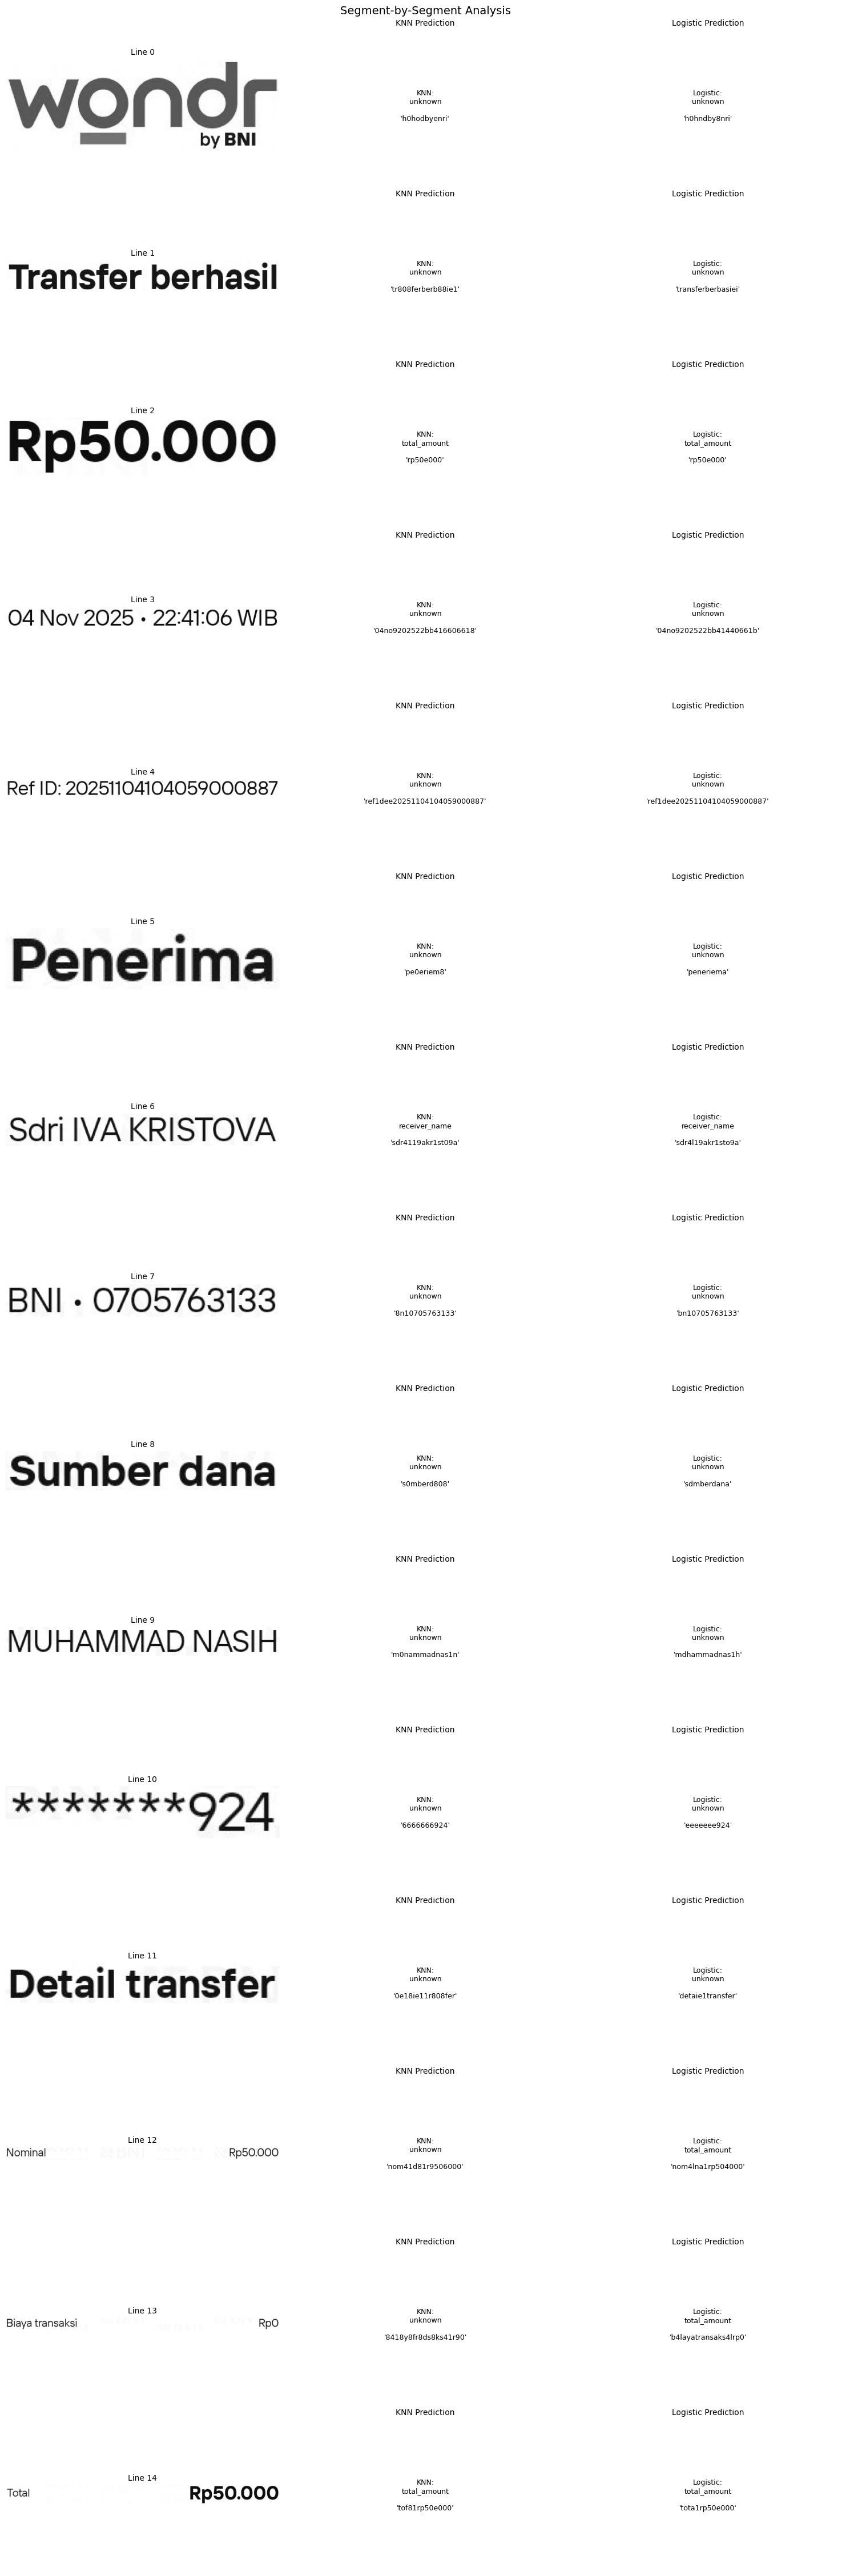

In [44]:
# Test with your image
def main(image_path: str, expected_amount: int) -> None:
    """Test with your actual receipt image"""

    expected_fields = {"total_amount": expected_amount}

    result, lines_data = layout_aware_receipt_verification(image_path, expected_fields)

    print("\n" + "=" * 60)
    print("DETAILED LAYOUT ANALYSIS:")
    print("=" * 60)
    for line in lines_data:
        print(f"Line {line['line_number']:2d}:")
        print(f"   KNN     -> {line['field_knn']:15} | '{line['text_knn']}'")
        print(f"   Logistic-> {line['field_logistic']:15} | '{line['text_logistic']}'")

    # Add visualization for each segment
    print("\n" + "=" * 60)
    print("VISUALIZING EACH SEGMENT:")
    print("=" * 60)

    # Load the original image for cropping
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grid layout
    num_lines = len(lines_data)
    cols = 3  # 3 columns: segment image, KNN text, Logistic text
    rows = num_lines

    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

    # Handle single row case
    if rows == 1:
        axes = axes.reshape(1, -1)

    for i, line in enumerate(lines_data):
        # Get bounding box for entire line
        boxes = line["boxes"]
        if not boxes:
            continue

        # Calculate combined bounding box for all boxes in the line
        x_min = min(box[0] for box in boxes)
        y_min = min(box[1] for box in boxes)
        x_max = max(box[0] + box[2] for box in boxes)
        y_max = max(box[1] + box[3] for box in boxes)

        # Extract line ROI
        line_roi = gray[y_min:y_max, x_min:x_max]

        # Display segment image
        axes[i, 0].imshow(line_roi, cmap="gray")
        axes[i, 0].set_title(f"Line {line['line_number']}", fontsize=10)
        axes[i, 0].axis("off")

        # Display KNN prediction
        axes[i, 1].text(
            0.5,
            0.5,
            f"KNN:\n{line['field_knn']}\n\n'{line['text_knn']}'",
            ha="center",
            va="center",
            fontsize=9,
            wrap=True,
        )
        axes[i, 1].set_title("KNN Prediction", fontsize=10)
        axes[i, 1].axis("off")

        # Display Logistic prediction
        axes[i, 2].text(
            0.5,
            0.5,
            f"Logistic:\n{line['field_logistic']}\n\n'{line['text_logistic']}'",
            ha="center",
            va="center",
            fontsize=9,
            wrap=True,
        )
        axes[i, 2].set_title("Logistic Prediction", fontsize=10)
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.suptitle("Segment-by-Segment Analysis", fontsize=14, y=1.002)
    plt.show()


# Execute
main(image_path="../input/new/template_02.jpg", expected_amount=50000)